# AmBe Data
The AmBe data was taken with the 9Li trigger. We launch 1820 readout windows, each of them 270 $\mu s$ long with 7 $\mu s$ between them, after those 1820
windows, we wait 20 (or whatever) seconds, and then another burst of 1820 windows.

7 $\mu s$ = 7e3 ns\
20 s       = 2e10 ns = 2e7 $\mu s$


In [1]:
import sys
import os

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')
sys.path.append("/eos/home-d/dcostasr/SWAN_projects/software/wcte_software/")

import hipy.pltext       as pltext
import hipy.utils        as ut
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import matplotlib.colors as colors

from src.read_data                   import load_concatenated, read_parquet, nHits
from tqdm.notebook                   import tqdm
from WCTE_event_display.EventDisplay import EventDisplay
from scipy.special import factorial


%load_ext autoreload
%autoreload 2

pltext.style()

## Read Data

In [2]:
# ============= LOADS THE DATA ===================
run  = 2389
data = load_concatenated(outdir=f"/eos/home-d/dcostasr/SWAN_projects/AmBe/tmp_parquet/{run}_calibrated")

In [ ]:
# =============== MASK OUT CARDS 130-132 ===================
run_cards, run_channels, run_slots, run_positions, run_times, run_events, run_charges, run_window_times = read_parquet(data, mask=True)

In [ ]:
run_times_sorted = ak.sort(run_times) - run_window_times

In [ ]:
run_window_times_sorted = ak.sort(run_window_times, axis=0)

## Check That Data Makes Sense. I.E.: Separation between bunches is 20 s and separation between windows is 7 $\mu s$

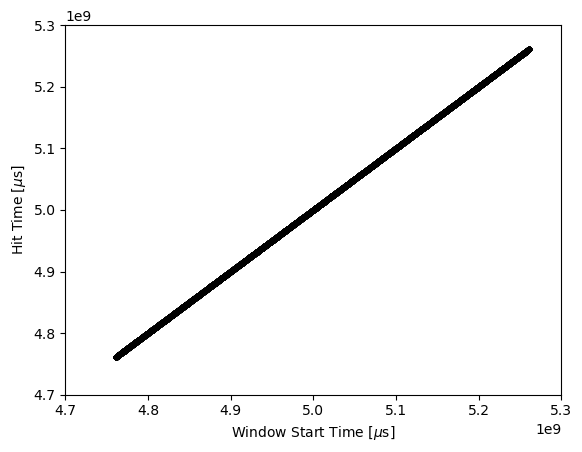

In [ ]:
plt.scatter(ak.ravel(run_window_times)[::100], ak.ravel(run_times)[::100], marker=".");
plt.ylabel("Hit Time [$\mu$s]");
plt.xlabel("Window Start Time [$\mu$s]");

# plt.vlines(ak.sort(run_window_times)[0][0], 0, 6e10);
# plt.vlines(run_window_times[0][0]+2e10, 0, 6e10);
# plt.vlines(run_window_times[0][0]+4e10, 0, 6e10);

plt.xlim(0.47e10, 0.53e10);
plt.ylim(0.47e10, 0.53e10);

Time Between Windows 277.752
Lenght Of the Window 173.7147577724457


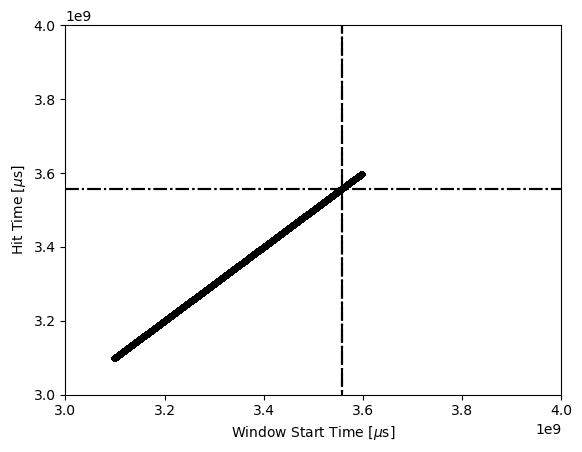

In [ ]:
plt.scatter(ak.ravel(run_window_times), ak.ravel(run_times), marker=".");
plt.ylabel("Hit Time [$\mu$s]");
plt.xlabel("Window Start Time [$\mu$s]");

plt.vlines(ak.sort(run_window_times)[0][0], 0, 6e10, linestyle="-.");
plt.vlines(ak.sort(run_window_times)[0][0]+2.7e5, 0, 6e10, linestyle="-.");
plt.vlines(ak.sort(run_window_times)[0][0]+2.7e5+7e3, 0, 6e10, linestyle="--");

plt.hlines(ak.sort(run_times)[0][0], 0, 6e10, linestyle="-.");
plt.hlines(ak.sort(run_times)[0][0]+2.7e5, 0, 6e10, linestyle="-.");

# plt.xlim(0.309805e10, 0.30985e10);
# plt.ylim(0.30980e10, 0.309875e10);

plt.xlim(0.3e10, 0.4e10);
plt.ylim(0.3e10, 0.4e10);

print("Time Between Windows", (run_window_times[1][0] - run_window_times[0][0])*1e-3)
print("Lenght Of the Window", (run_times[0][-1] - run_times[0][0])*1e-3)

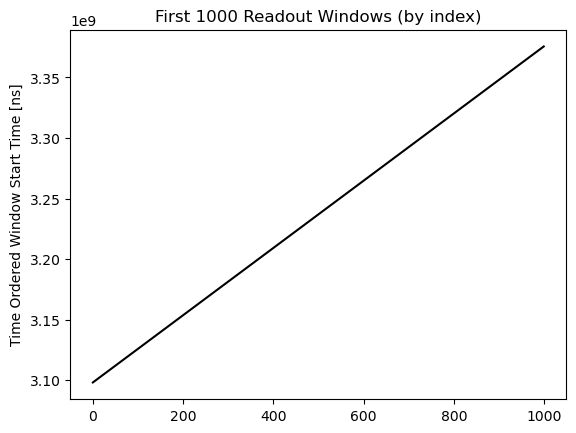

In [ ]:
plt.plot(run_window_times_sorted[:,0][:1000]);
plt.ylabel("Time Ordered Window Start Time [ns]");
plt.title("First 1000 Readout Windows (by index)");

## Looking At Readout Windows

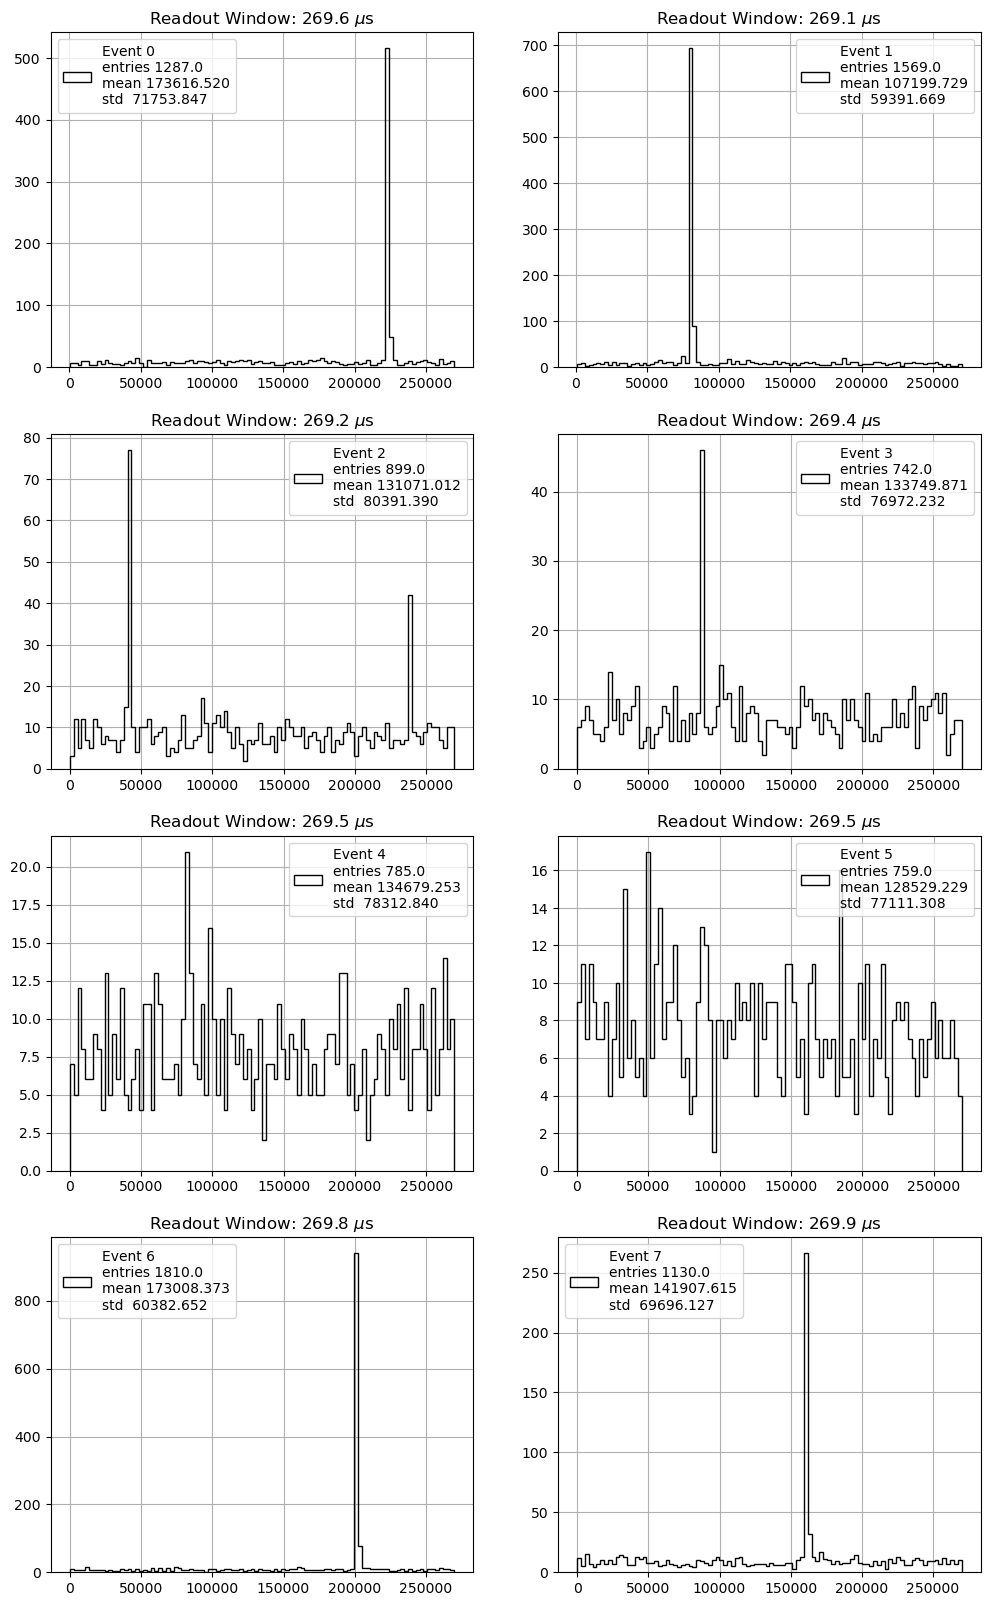

In [ ]:
subplot = pltext.canvas(8)

for i,event in enumerate(range(8)):
    subplot(i+1)
    pltext.hist(run_times_sorted[event], 100, label=f"Event {event}");
    plt.title(f"Readout Window: {(run_times_sorted[event][-1] - run_times_sorted[event][0])*1e-3:.1f} $\mu$s")

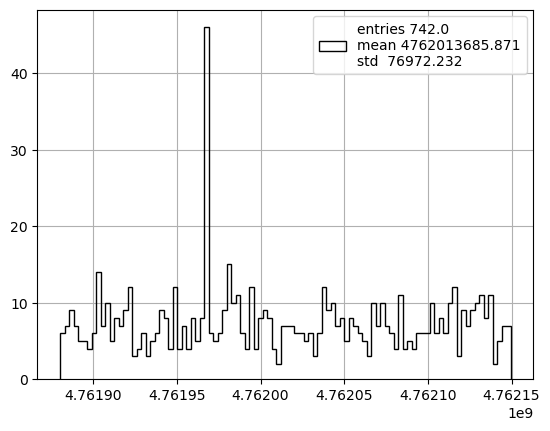

In [ ]:
data = run_times[3]
hist_range=(3.557e9+577000, 3.557e9+578500)
indices_in_range = np.where((data >= hist_range[0]) & (data <= hist_range[1]))[0]

pltext.hist(data, 100, range=None);
# plt.title(f"Window Lenght: {data[indices_in_range][-1] - data[indices_in_range][0]:.2f} ns. {len(data[indices_in_range])} Hits");

### Event Display

(2014,)


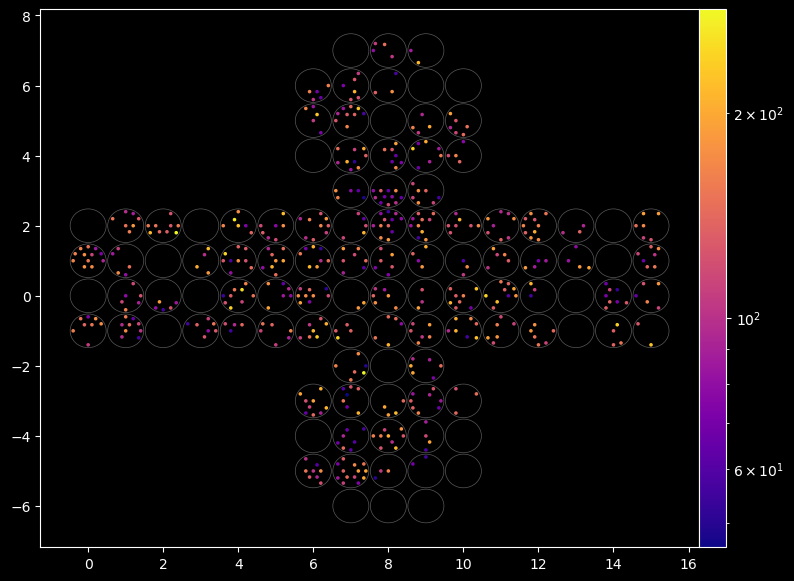

In [ ]:
event = 5
pmt_id = (run_slots[event]*19 + run_positions[event])
data_to_plot = run_charges[event]#[indices_in_range]

eventDisplay = EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

ev_disp_data = eventDisplay.process_data(pmt_id, data_to_plot, sum_data=False)
eventDisplay.plotEventDisplay(ev_disp_data, color_norm=colors.LogNorm(), style="dark_background", fig_width=10)

plt.show(block=False)
plt.style.use('default');

pltext.style()

# nHits To Find Spills and AfterPulsing

In [ ]:
triggered_spill_hits_index = nHits(mode="multiple_events", hit_times=run_times_sorted, w=5000, thresh_min=100, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)

100%|██████████| 157955/157955 [00:40<00:00, 3865.07it/s]


In [ ]:
# from matplotlib.backends.backend_pdf import PdfPages

# with PdfPages("./nHits_Spills.pdf") as pdf:
#     for key, value in tqdm(triggered_spill_hits_index.items(), total=len(triggered_spill_hits_index.items())):
#         event = key
#         data = run_times_sorted[event]
#         pltext.hist(data,                                                        100, range=(data[0], data[-1]), label=f"Event {event}");
#         pltext.hist(data[np.concatenate(triggered_spill_hits_index.get(event))], 100, range=(data[0], data[-1]), label="Triggered Hits");
        
#         plt.title(f"Readout Window: {(data[-1] - data[0])*1e-3:.1f} $\mu$s")

#         pdf.savefig()  
#         plt.close()

NameError: name 'triggered_spill_hits_index' is not defined

This seems to work quite well. Now is time to remove those hits from the readout windows

In [ ]:
noSpill_hit_times = []
for key, value in tqdm(triggered_spill_hits_index.items(), total=len(triggered_spill_hits_index)):
    event = key
    data  = run_times_sorted[event]
    trigger_indices = np.concatenate(triggered_spill_hits_index.get(event))
    all_indices     = np.arange(len(data))
    invalid_indices = np.setdiff1d(all_indices, trigger_indices)
    noSpill_hit_times.append(data[invalid_indices])

noSpill_hit_times = ak.Array(noSpill_hit_times)

  0%|          | 0/64011 [00:00<?, ?it/s]

Agora preciso atopar os eventos que o nHits para atopar Spills non está tendo en conta

In [ ]:
total_events = np.arange(len(run_times_sorted))
spill_events = [key for key,value in tqdm(triggered_spill_hits_index.items(), total=len(triggered_spill_hits_index))]

noSpill_events = [i for i in tqdm(total_events, total=len(total_events)) if i not in spill_events]

  0%|          | 0/64011 [00:00<?, ?it/s]

  0%|          | 0/157955 [00:00<?, ?it/s]

In [ ]:
corrected_run_times_sorted = ak.sort(ak.concatenate([run_times_sorted[noSpill_events], noSpill_hit_times], axis=0))

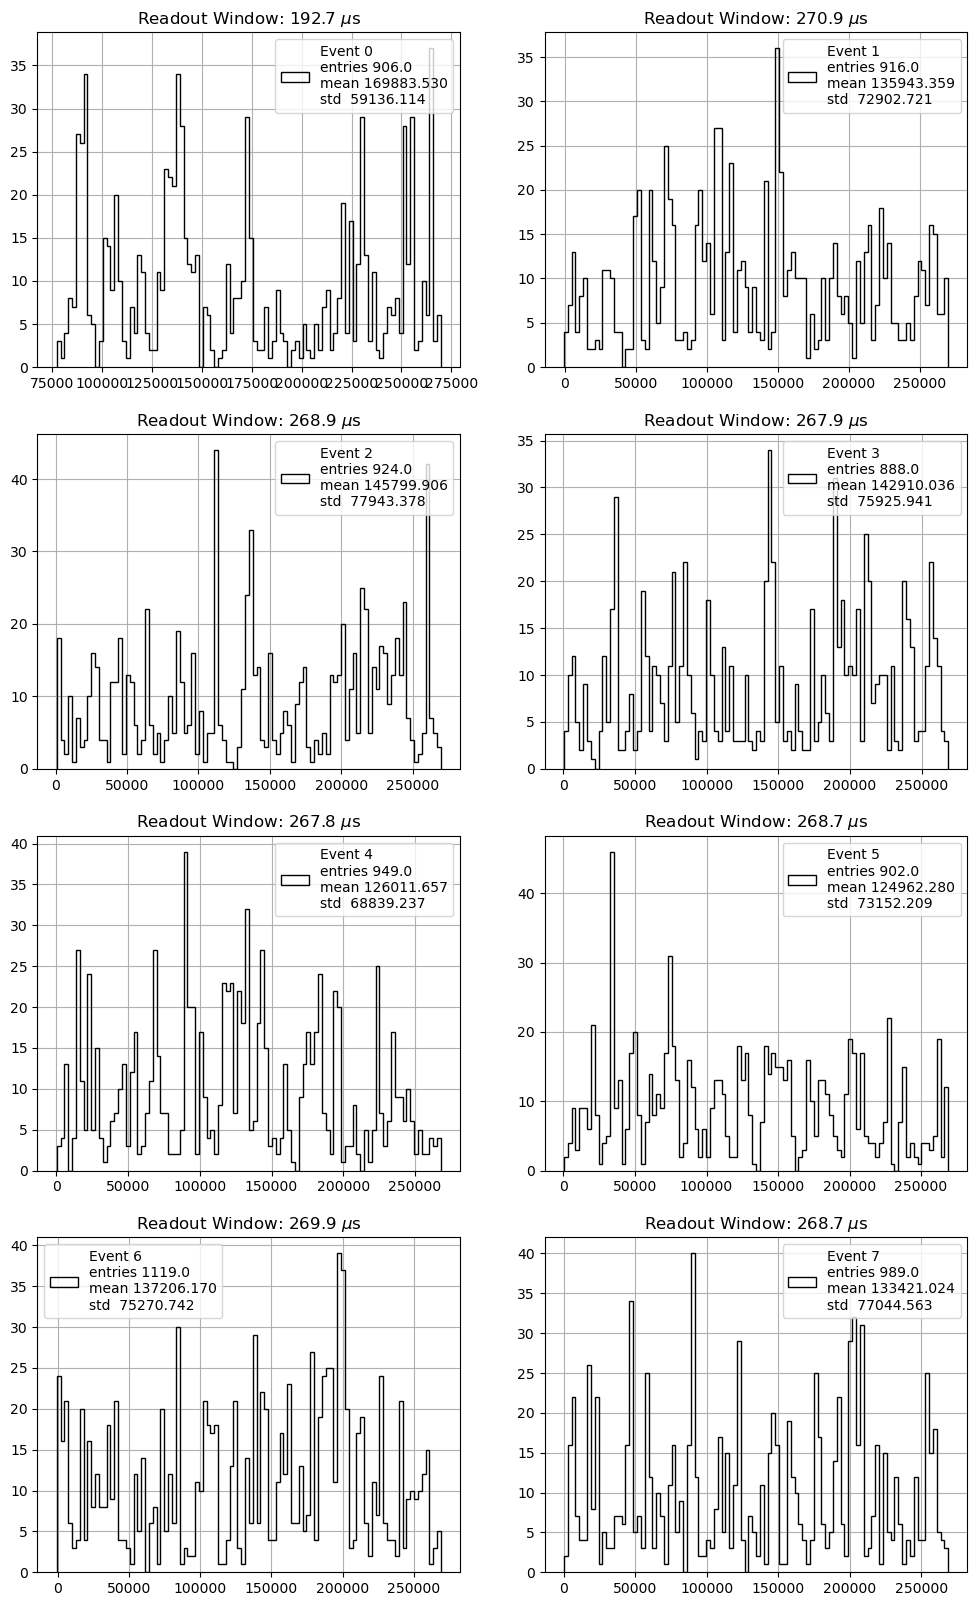

In [ ]:
subplot = pltext.canvas(8)

for i,event in enumerate(range(8)):
    subplot(i+1)
    data = corrected_run_times_sorted[event]
    pltext.hist(data, 100, label=f"Event {event}");
    plt.title(f"Readout Window: {(data[-1] - data[0])*1e-3:.1f} $\mu$s")

### Cantas Veces Trigga O Algoritmo Para Os Spills?

In [ ]:
total_no_triggers = []
for key, values in triggered_spill_hits_index.items():
    total_no_triggers.append(len(triggered_spill_hits_index.get(key)))

In [ ]:
np.sum(total_no_triggers)

63062

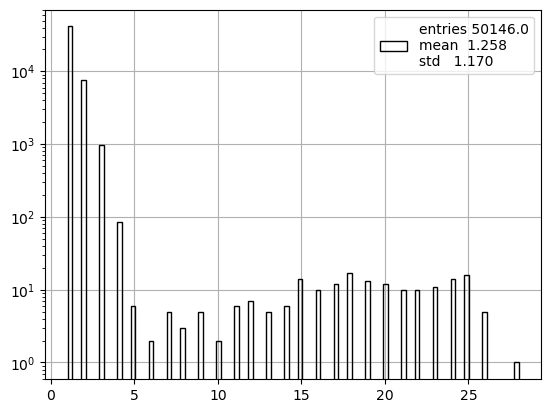

In [ ]:
pltext.hist(total_no_triggers, 100, ylog=True);